In [2]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
from scipy import stats
import sklearn
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import cv2
import numpy as np
from PIL import Image, ImageChops, ImageDraw
from IPython.display import display
from skimage import io, img_as_float
from scipy.stats import ttest_ind, chi2_contingency, combine_pvalues, chisquare, norm
import tabulate

# Step 1
Load data

In [3]:
with uproot.open('toyForStudents_5.root') as datafile:
    data_df = datafile['R0Tree'].arrays(library='pd')

# Step 2
First data look

In [4]:
df = pd.DataFrame(data_df)
df

,x,y,id,sample
0,3.460569,0.673391,1,1
1,3.075171,0.761314,1,1
2,2.746258,1.339751,1,1
3,2.190463,2.049242,1,1
4,3.988466,0.707543,1,1
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [5]:
df_id_minus_1 = df[df['id'] == -1]
df_id_1 = df[df['id'] == 1]

In [6]:
df_id_minus_1

,x,y,id,sample
1700000,3.524324,2.084737,-1,1
1700001,3.497870,1.261757,-1,1
1700002,2.418601,1.440717,-1,1
1700003,3.495933,1.956262,-1,1
1700004,2.284854,2.110827,-1,1
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [7]:
df_id_1

,x,y,id,sample
0,3.460569,0.673391,1,1
1,3.075171,0.761314,1,1
2,2.746258,1.339751,1,1
3,2.190463,2.049242,1,1
4,3.988466,0.707543,1,1
...,...,...,...,...
1699995,2.924093,1.452403,1,17
1699996,2.067248,1.737031,1,17
1699997,2.581711,1.004430,1,17
1699998,4.302710,1.388870,1,17


In [8]:
def print_images():
    grouped_minus_1 = df_id_minus_1.groupby('sample')
    grouped_1 = df_id_1.groupby('sample')

    for sample, group_minus_1 in grouped_minus_1:
        group_1 = grouped_1.get_group(sample)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # DLA id = -1
        axs[0].scatter(group_minus_1['x'], group_minus_1['y'], label='id = -1', color='blue', marker=',', s=1)
        axs[0].set_title(f'Obrazek dla sample {sample} (id = -1)')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        axs[0].legend()

        # DLA id = 1
        axs[1].scatter(group_1['x'], group_1['y'], label='id = 1', color='red', marker=",", s=1)
        axs[1].set_title(f'Obrazek dla sample {sample} (id = 1)')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('y')
        axs[1].legend()

        plt.tight_layout()
        plt.show()


# Step 3
Plots, interpolated

In [9]:
# print_images()

# Step 4
Save cloud points as png files to get exact images

In [10]:
def get_model_training_images(sample):
    data_id_minus_1 = df_id_minus_1[(df_id_minus_1['sample'] == sample) & (df_id_minus_1['id'] == -1)]
    data_id_1 = df_id_1[(df_id_1['sample'] == sample) & (df_id_1['id'] == 1)]

    return data_id_minus_1, data_id_1

In [11]:
a, b = get_model_training_images(17)

In [12]:
a

,x,y,id,sample
3300000,3.140368,2.036576,-1,17
3300001,3.498585,0.740953,-1,17
3300002,3.234064,1.930019,-1,17
3300003,2.658791,0.798944,-1,17
3300004,3.423107,2.123055,-1,17
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [13]:
b

,x,y,id,sample
1600000,4.465685,0.796268,1,17
1600001,4.763283,0.922533,1,17
1600002,2.679387,1.167562,1,17
1600003,3.276646,1.320163,1,17
1600004,3.004393,1.491962,1,17
...,...,...,...,...
1699995,2.924093,1.452403,1,17
1699996,2.067248,1.737031,1,17
1699997,2.581711,1.004430,1,17
1699998,4.302710,1.388870,1,17


In [14]:
def save_point_cloud_as_image(dataframe, filename):
    width = 6000
    height = 6000
    padding = 5

    min_x = dataframe['x'].min()
    max_x = dataframe['x'].max()
    min_y = dataframe['y'].min()
    max_y = dataframe['y'].max()
    
    x_scale = (width - 2 * padding) / (max_x - min_x)
    y_scale = (height - 2 * padding) / (max_y - min_y)

    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)

    for _, row in dataframe.iterrows():
        x = int((row['x'] - min_x) * x_scale) + padding
        y = int((row['y'] - min_y) * y_scale) + padding
        draw.point((x, height - y - 1), fill="black")  # Invert y to match image coordinates

    image.save(filename)


In [15]:
max_sample = df['sample'].max()
print("Max value for 'sample' column:", max_sample)

Max value for 'sample' column: 17


In [16]:
for i in range(1, max_sample+1, 1):
    print(f"========== SAMPLE {i} ==========")
    img_minus, img = get_model_training_images(i)
    save_point_cloud_as_image(img_minus, f"cloud_points_to_images_minus/img_minus_{i}.png")
    save_point_cloud_as_image(img, f"cloud_points_to_images/img_{i}.png")
    print(f"Sample {i} saved to cloud_points_to_images/ folder.")
print(f"================================")
print("Conversion done.")

========== SAMPLE 1 ==========
Sample 1 saved to cloud_points_to_images/ folder.
========== SAMPLE 2 ==========
Sample 2 saved to cloud_points_to_images/ folder.
========== SAMPLE 3 ==========
Sample 3 saved to cloud_points_to_images/ folder.
========== SAMPLE 4 ==========
Sample 4 saved to cloud_points_to_images/ folder.
========== SAMPLE 5 ==========
Sample 5 saved to cloud_points_to_images/ folder.
========== SAMPLE 6 ==========
Sample 6 saved to cloud_points_to_images/ folder.
========== SAMPLE 7 ==========
Sample 7 saved to cloud_points_to_images/ folder.
========== SAMPLE 8 ==========
Sample 8 saved to cloud_points_to_images/ folder.
========== SAMPLE 9 ==========
Sample 9 saved to cloud_points_to_images/ folder.
========== SAMPLE 10 ==========
Sample 10 saved to cloud_points_to_images/ folder.
========== SAMPLE 11 ==========
Sample 11 saved to cloud_points_to_images/ folder.
========== SAMPLE 12 ==========
Sample 12 saved to cloud_points_to_images/ folder.
========== SAMPLE 13 =

# Step 5
Cluster analysis
https://scikit-learn.org/stable/modules/clustering.html

## PIL library

In [17]:
def PIL_diff(img1, img2):
    diff = ImageChops.difference(img1, img2)
    if diff.getbbox():
        # yellow_bg = Image.new("RGB", diff.size, "yellow")
        # result = ImageChops.add(yellow_bg, diff)
        # display(result)
        display(diff)
    else:
        print("No differences")

In [18]:
def load_image_from_folder(folder, filename):
    path = f"{folder}/{filename}"
    return Image.open(path)

img_minus_1_loaded = load_image_from_folder("cloud_points_to_images_minus", "img_minus_1.png")
img_1_loaded = load_image_from_folder("cloud_points_to_images", "img_1.png")

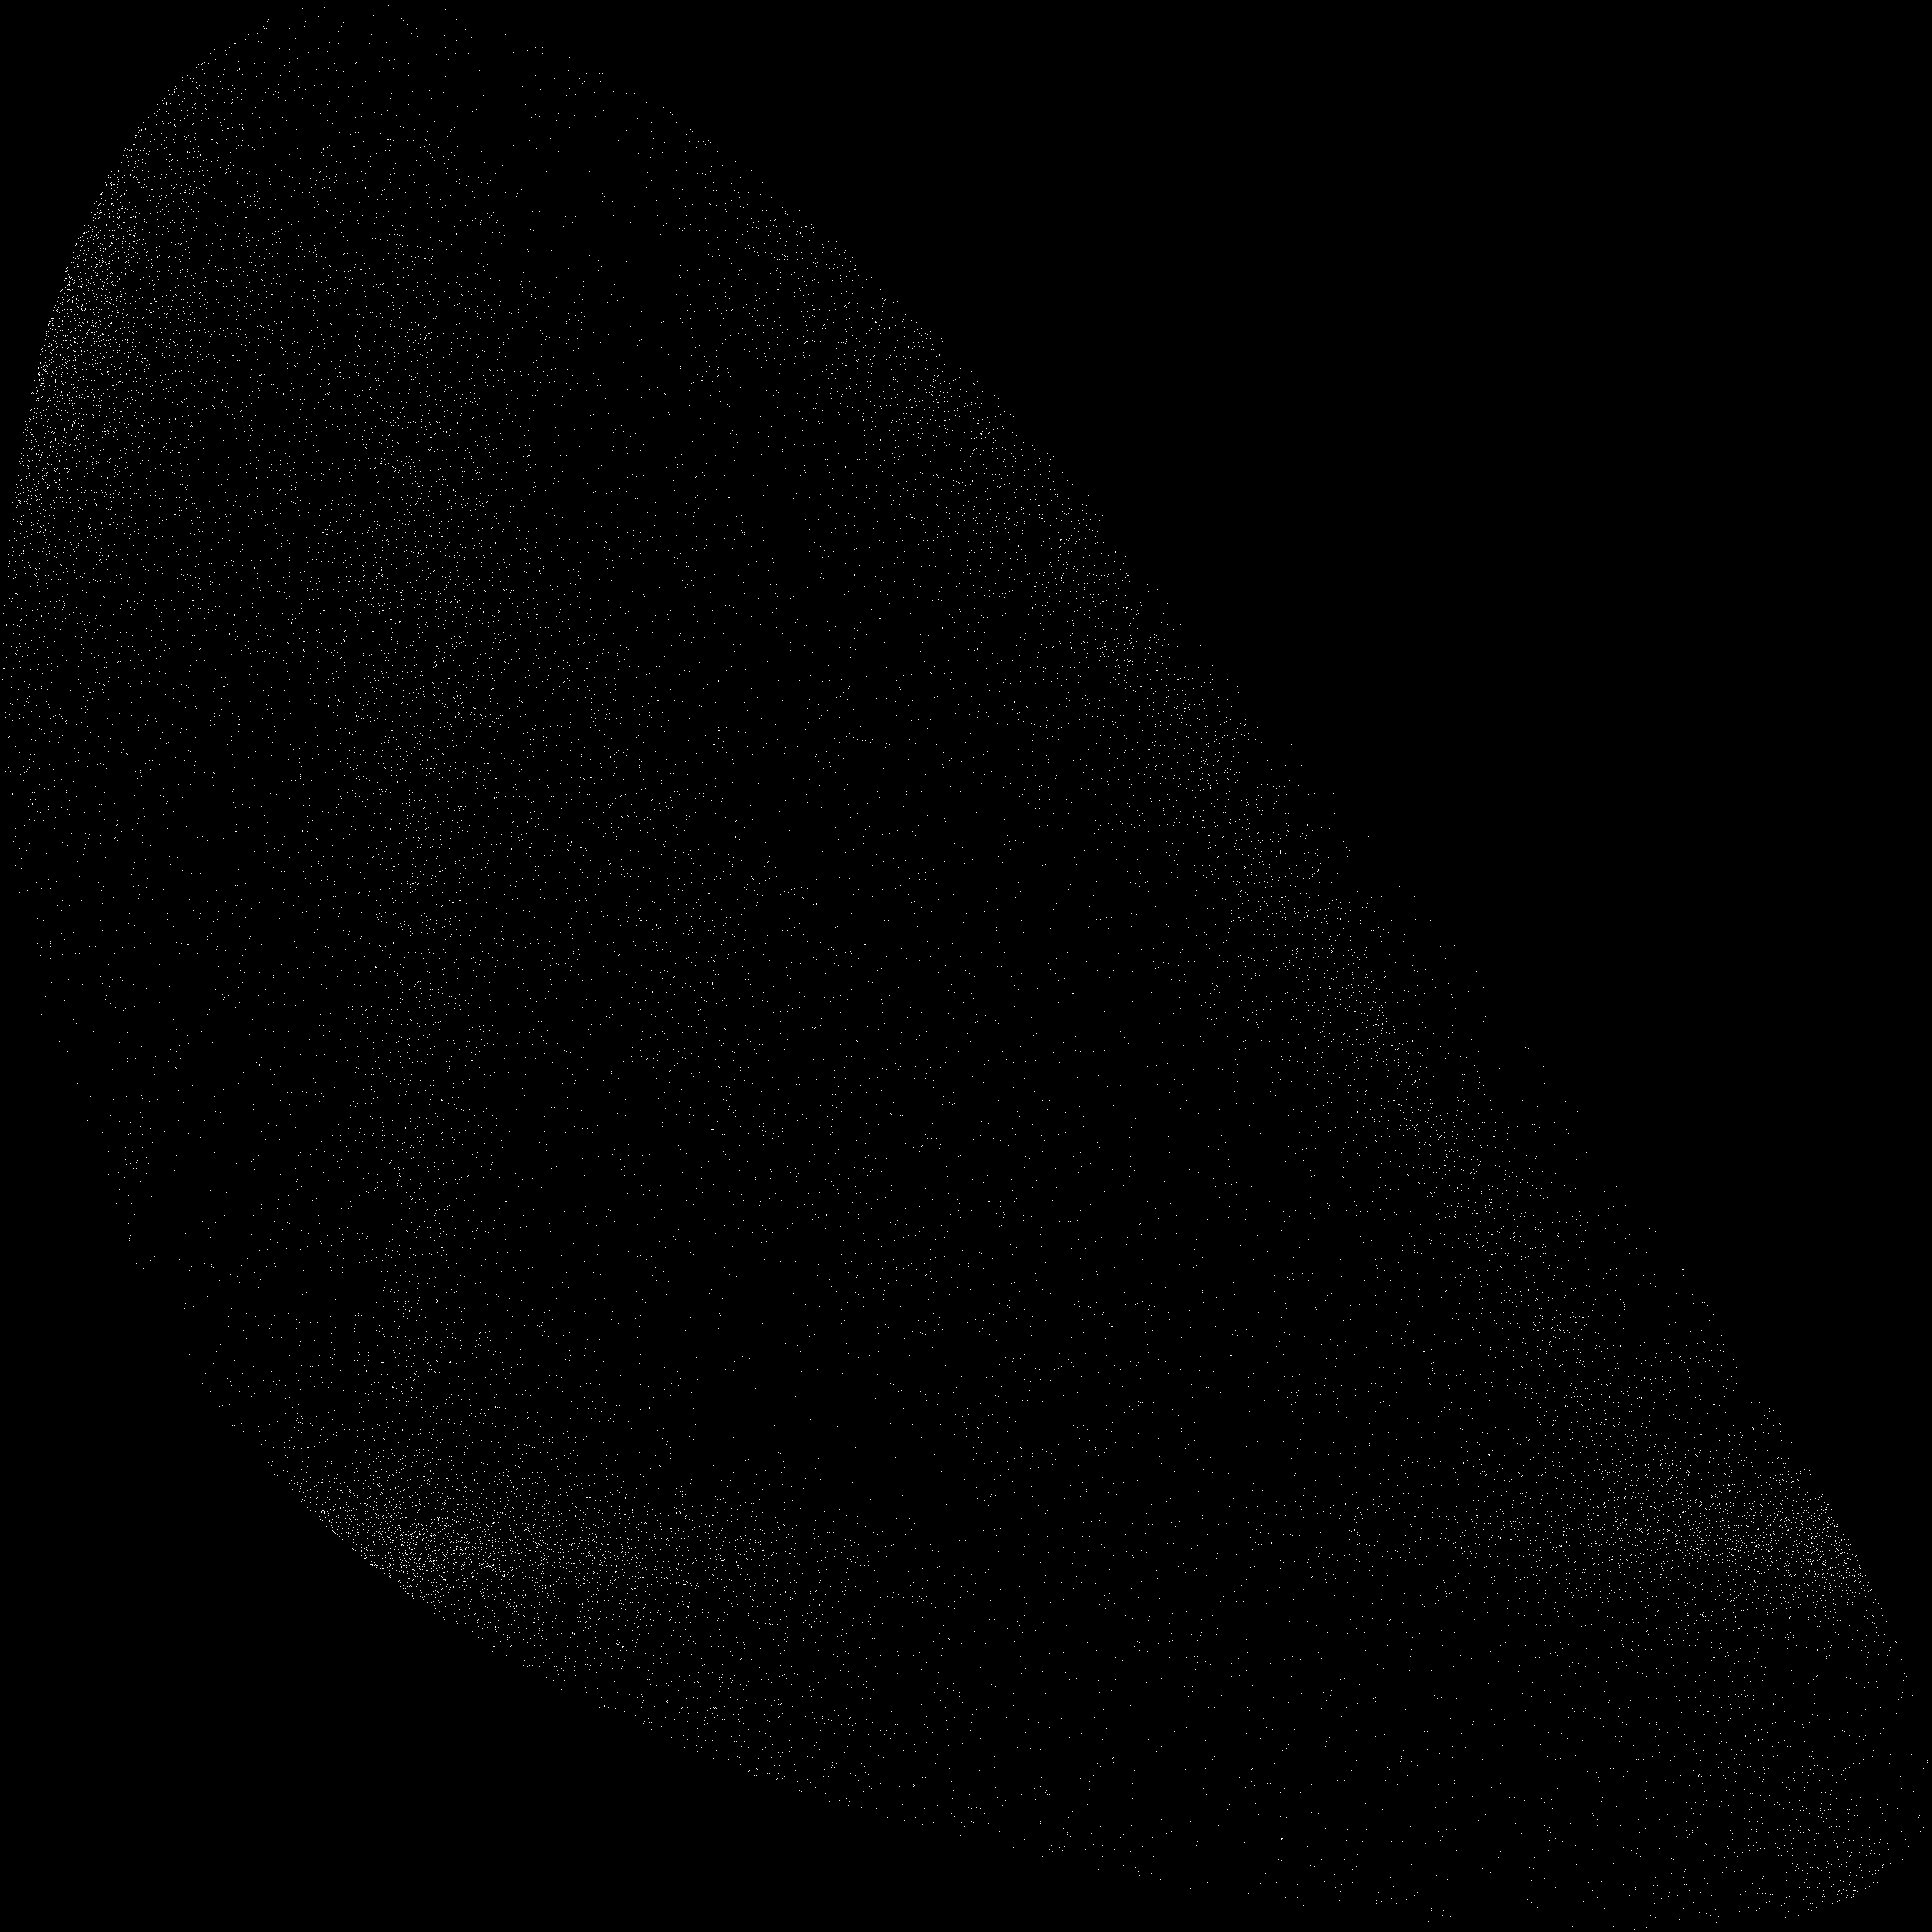

In [19]:
PIL_diff(img_minus_1_loaded, img_1_loaded)

## K-Means

In [20]:
img_minus_1_loaded = cv2.imread('cloud_points_to_images_minus/img_minus_1.png')
img_1_loaded = cv2.imread('cloud_points_to_images/img_1.png')

In [21]:
def detect_image_differences(img1, img2, num_clusters):
    img_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    points = np.where(img_gray == 0)
    coordinates = np.column_stack((points[1], points[0]))
    df_coordinates = pd.DataFrame(coordinates, columns=['x', 'y'])

    img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    points2 = np.where(img_gray2 == 0)
    coordinates2 = np.column_stack((points2[1], points2[0]))
    df_coordinates2 = pd.DataFrame(coordinates2, columns=['x', 'y'])

    combined_data = np.vstack((df_coordinates, df_coordinates2))

    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, 15)

    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(combined_data)
        kmeanModel.fit(combined_data)

        # distortions
        distortions.append(sum(np.min(cdist(combined_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / combined_data.shape[0])

        # inertias
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(combined_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / combined_data.shape[0]
        mapping2[k] = kmeanModel.inertia_

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

    num_clusters = num_clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(combined_data)

    # add cluster value to each coordinates
    df_coordinates['cluster'] = labels[:len(df_coordinates)]
    df_coordinates2['cluster'] = labels[len(df_coordinates):]

    combined_data_clusters = np.vstack((df_coordinates, df_coordinates2))
    combined_data_clusters = pd.DataFrame(combined_data_clusters, columns=['x', 'y', 'cluster'])
   

    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = combined_data_clusters[combined_data_clusters['cluster'] == cluster]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster}', alpha=0.5, s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Combined image')
    plt.legend()


    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = df_coordinates[df_coordinates['cluster'] == cluster]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster}', alpha=0.5, s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('First image')
    plt.legend()

    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = df_coordinates2[df_coordinates2['cluster'] == cluster]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster}', alpha=0.5, s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Second image')
    plt.legend()
    plt.show()


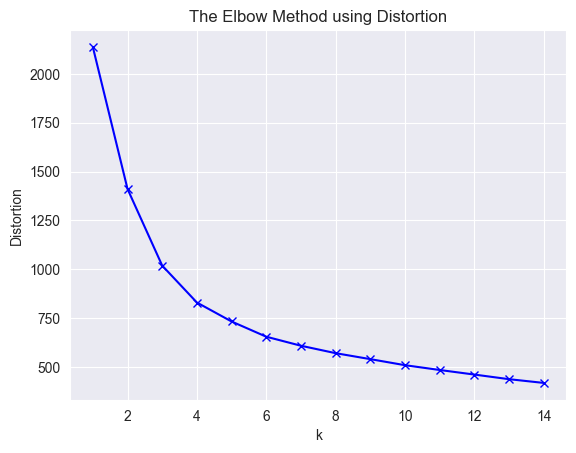

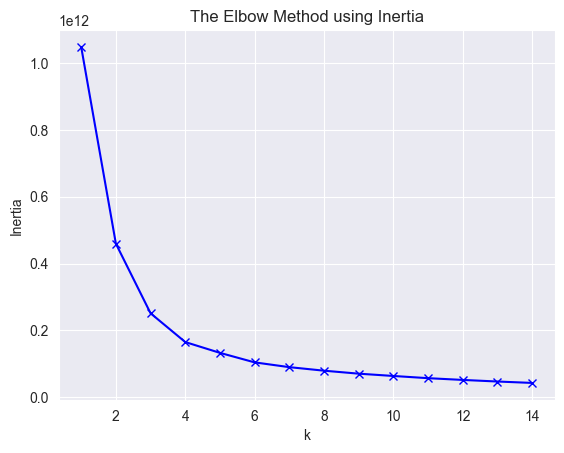

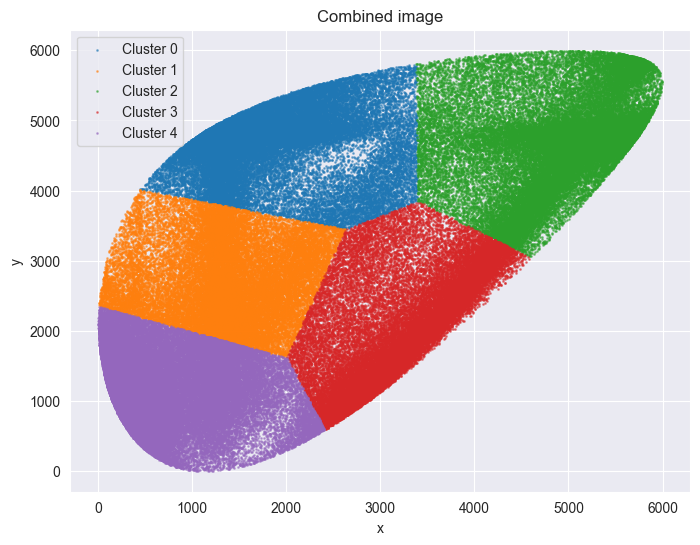

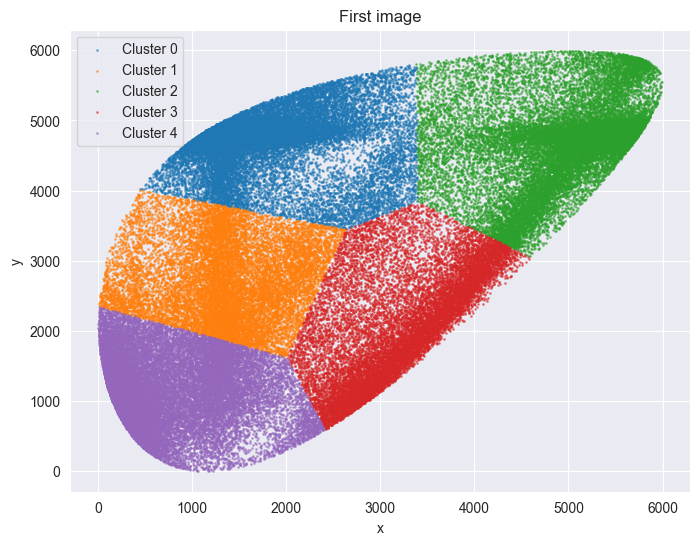

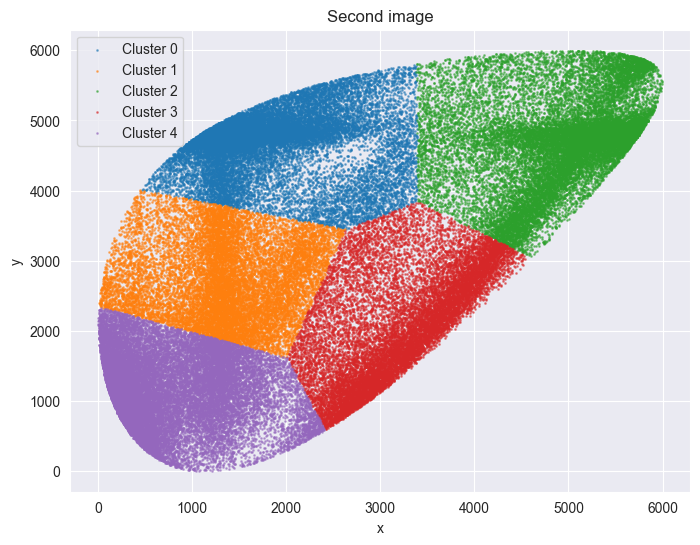

In [22]:
detect_image_differences(img_minus_1_loaded, img_1_loaded, 5)

## Metoda Fishera
Polega na połączeniu kilku p-wartości w jedną skumulowaną p-wartość, co pozwala na jednoczesne uwzględnienie wyników kilku niezależnych testów.

In [23]:
def points_per_cluster(img, img2, num_clusters):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # save all black pixels and its location as x y
    points = np.where(img_gray == 0)
    coordinates = np.column_stack((points[1], points[0]))
    df_coordinates = pd.DataFrame(coordinates, columns=['x', 'y'])

    # load second picture in gray
    img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # save all black pixels and its location as x y
    points2 = np.where(img_gray2 == 0)
    coordinates2 = np.column_stack((points2[1], points2[0]))
    df_coordinates2 = pd.DataFrame(coordinates2, columns=['x', 'y'])

    combined_data = np.vstack((df_coordinates, df_coordinates2))

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(combined_data)

    df_coordinates['cluster'] = labels[:len(df_coordinates)]
    df_coordinates2['cluster'] = labels[len(df_coordinates):]

    combined_data_clusters = np.vstack((df_coordinates, df_coordinates2))
    combined_data_clusters = pd.DataFrame(combined_data_clusters, columns=['x', 'y', 'cluster'])

    cluster_counts_df1 = df_coordinates.groupby('cluster').size().rename('size_df1')
    cluster_counts_df2 = df_coordinates2.groupby('cluster').size().rename('size_df2')

    cluster_comparison = pd.merge(cluster_counts_df1, cluster_counts_df2, how='outer', left_index=True, right_index=True)

    cluster_comparison['df1_to_df2'] = cluster_comparison['size_df1'] / cluster_comparison['size_df2']

    print(cluster_comparison)
    print()

    return cluster_counts_df1, cluster_counts_df2

In [24]:
cluster_counts_df1, cluster_counts_df2 = points_per_cluster(img_minus_1_loaded, img_1_loaded, 5)

         size_df1  size_df2  df1_to_df2
cluster                                
0           21722     21099    1.029527
1           15287     15547    0.983277
2           22718     22128    1.026663
3           15449     15951    0.968529
4           24326     24791    0.981243



In [25]:
def statistical_tests(cluster_counts_df1, cluster_counts_df2, num_clusters, sample_id):
    print(f"Sample:{sample_id} - UNCROSSED CLUSTERS IDS")
    for i in range(num_clusters):
        cluster_count_im1 = cluster_counts_df1.loc[i]
        cluster_count_im2 = cluster_counts_df2.loc[i]

        contingency_table = np.array([
            [cluster_count_im1, 100000 - cluster_count_im1],
            [cluster_count_im2, 100000 - cluster_count_im2]
        ])

        chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

        if p_value == 1:
            std_devs = 0
        else:
            std_devs = norm.ppf(1 - p_value)

        print(f'CLUSTER {i}: chi2 = {chi2_stat:.4f} ; p-value = {p_value:.4e} ; n_sigma = {std_devs:.4f}')

    crossed_clusters_p_values = []
    print(f"Sample:{sample_id} - CROSSED CLUSTERS IDS")
    for i in range(num_clusters):
        tmp = i + 1
        for j in range(tmp):
            if i != j:
                cluster_count_im1_i = cluster_counts_df1.loc[i]
                cluster_count_im2_i = cluster_counts_df2.loc[i]

                cluster_count_im1_j = cluster_counts_df1.loc[j]
                cluster_count_im2_j = cluster_counts_df2.loc[j]

                contingency_table = np.array([[cluster_count_im1_i, cluster_count_im1_j], [cluster_count_im2_i, cluster_count_im2_j]])

                chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
                if p_value == 1:
                    std_devs = 0
                else:
                    std_devs = norm.ppf(1 - p_value)

                print(f"CLUSTERS {i}/{j}: chi2 = {chi2_stat:.4f} ; p-value = {p_value:.4e} ; n_sigma = {std_devs:.4f}")
                
                crossed_clusters_p_values.append(p_value)
                    
    # combined_p_value_chi2 = combine_pvalues(crossed_clusters_p_values, method='fisher')[1]
    # print(f"Combined p-value using Fisher's method for CROSSED CLUSTERS (sample {sample_id}): {combined_p_value_chi2}")
    # return crossed_clusters_p_values, combined_p_value_chi2
    
    combined_p_value_chi2 = combine_pvalues(crossed_clusters_p_values, method='fisher')[1]
    if combined_p_value_chi2 == 1:
        combined_std_devs = 0
    else:
        combined_std_devs = norm.ppf(1 - combined_p_value_chi2)
    print(f"Combined p-value using Fisher's method for CROSSED CLUSTERS (sample {sample_id}): {combined_p_value_chi2:.4e} ; n_sigma = {combined_std_devs:.4f}")
    return crossed_clusters_p_values, combined_p_value_chi2

In [26]:
crossed_clusters_p_values, _ = statistical_tests(cluster_counts_df1, cluster_counts_df2, 5, 1)

Sample:1 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 11.4963 ; p-value = 6.9734e-04 ; n_sigma = 3.1958
CLUSTER 1: chi2 = 2.5721 ; p-value = 1.0876e-01 ; n_sigma = 1.2331
CLUSTER 2: chi2 = 9.9718 ; p-value = 1.5896e-03 ; n_sigma = 2.9499
CLUSTER 3: chi2 = 9.4824 ; p-value = 2.0745e-03 ; n_sigma = 2.8666
CLUSTER 4: chi2 = 5.8102 ; p-value = 1.5933e-02 ; n_sigma = 2.1461
Sample:1 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 9.4217 ; p-value = 2.1443e-03 ; n_sigma = 2.8561
CLUSTERS 2/0: chi2 = 0.0398 ; p-value = 8.4195e-01 ; n_sigma = -1.0025
CLUSTERS 2/1: chi2 = 8.4726 ; p-value = 3.6054e-03 ; n_sigma = 2.6870
CLUSTERS 3/0: chi2 = 16.8314 ; p-value = 4.0853e-05 ; n_sigma = 3.9393
CLUSTERS 3/1: chi2 = 0.8731 ; p-value = 3.5011e-01 ; n_sigma = 0.3850
CLUSTERS 3/2: chi2 = 15.6279 ; p-value = 7.7107e-05 ; n_sigma = 3.7842
CLUSTERS 4/0: chi2 = 13.1468 ; p-value = 2.8802e-04 ; n_sigma = 3.4427
CLUSTERS 4/1: chi2 = 0.0183 ; p-value = 8.9247e-01 ; n_sigma = -1.2398
CLUSTERS 4/2: chi2 = 11.9529 ; p-

In [27]:
def plot_distributions(p_values, sample_id):
    plt.figure(figsize=(10, 6))
    plt.hist(p_values, bins=50, range=(0, 1), edgecolor='black')
    plt.xlabel('p-value for crossed pairs of clusters')
    plt.ylabel('Cases')
    plt.title(f'Sample {sample_id}: Distribution of p-values for Crossed Clusters')
    plt.xlim(0, 1)
    plt.show()

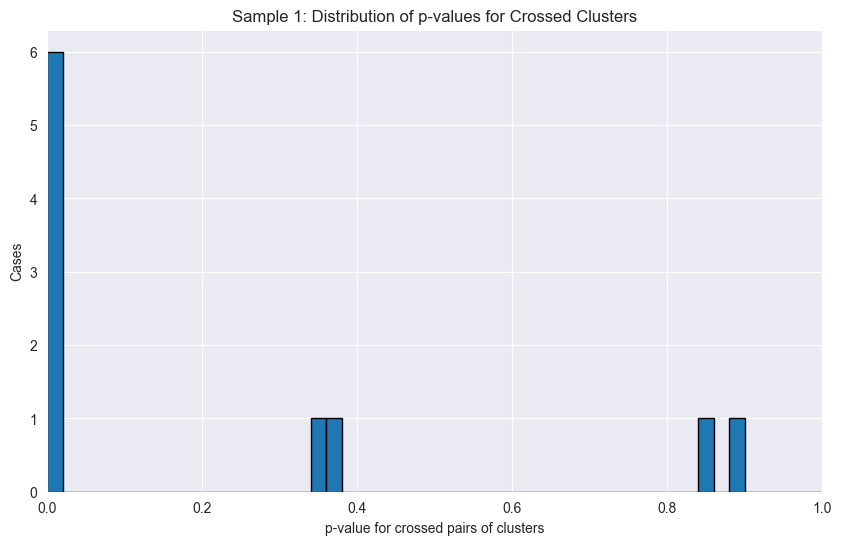

In [28]:
plot_distributions(crossed_clusters_p_values, 1)

H0: Obraz -1 i 1 są różne.
H1 (alterantywna): Obraz -1 i 1 są takie same.

In [29]:
def make_p_val_plots_uncrossed():
    pass

### p-value (wartość p)
#### Definicja:
p-value to prawdopodobieństwo uzyskania wyników co najmniej tak ekstremalnych jak zaobserwowane wyniki, zakładając, że hipoteza zerowa (brak efektu) jest prawdziwa.

#### Działanie:

Wyznaczenie hipotezy zerowej (H0): Hipoteza zerowa jest założeniem, że nie ma żadnego efektu lub różnicy.
Obliczenie statystyki testowej: Jest to miara używana do porównania z rozkładem teoretycznym.
Obliczenie p-value: p-value jest obliczane na podstawie rozkładu tej statystyki testowej. Jeśli p-value jest mniejsze niż wcześniej ustalony poziom istotności (np. 0.05), odrzucamy hipotezę zerową.
### Test t-Studenta (t-test)
#### Definicja:
Test t-Studenta jest używany do porównywania średnich dwóch grup, aby sprawdzić, czy różnica między nimi jest statystycznie istotna.

#### Rodzaje:
Test t dla jednej próby: Porównuje średnią próby z określoną wartością.
Test t dla dwóch próbek niezależnych: Porównuje średnie dwóch niezależnych grup.
Test t dla próbek sparowanych: Porównuje średnie dwóch zależnych grup (np. przed i po leczeniu).
#### Działanie:

Wyznaczenie hipotezy zerowej (H0): Zakłada się, że średnie dwóch grup są równe.
Obliczenie statystyki t: Statystyka t mierzy różnicę między średnimi dwóch grup, znormalizowaną przez zmienność w danych.
Obliczenie p-value: p-value jest obliczane na podstawie rozkładu t. Jeśli p-value jest mniejsze niż poziom istotności, odrzucamy hipotezę zerową.
### Test chi-kwadrat (chi2)
#### Definicja:
Test chi-kwadrat jest używany do badania zależności między dwiema zmiennymi kategorycznymi lub do sprawdzenia, czy obserwowane rozkłady różnią się od oczekiwanych rozkładów.
#### Rodzaje:
Test niezależności chi-kwadrat: Sprawdza, czy istnieje zależność między dwiema zmiennymi kategorycznymi.
Test dopasowania chi-kwadrat: Sprawdza, czy obserwowany rozkład różni się od oczekiwanego rozkładu.
#### Działanie:

Wyznaczenie hipotezy zerowej (H0): Zakłada się, że nie ma zależności między zmiennymi lub że obserwowany rozkład nie różni się od oczekiwanego.
Obliczenie statystyki chi-kwadrat: Statystyka chi-kwadrat mierzy sumę kwadratów różnic między obserwowanymi a oczekiwanymi częstotliwościami, podzieloną przez oczekiwane częstotliwości.
Obliczenie p-value: p-value jest obliczane na podstawie rozkładu chi-kwadrat. Jeśli p-value jest mniejsze niż poziom istotności, odrzucamy hipotezę zerową.

### Jak działają w praktyce?
### Przykład z p-value
Załóżmy, że badamy nowy lek i chcemy sprawdzić, czy jest on bardziej skuteczny niż placebo. Nasza hipoteza zerowa (H0) to „lek nie jest bardziej skuteczny niż placebo”.

Jeśli po przeprowadzeniu testu statystycznego otrzymamy p-value = 0.03 i nasz poziom istotności wynosi 0.05, odrzucamy hipotezę zerową i stwierdzamy, że lek jest statystycznie bardziej skuteczny niż placebo.
Jeśli p-value = 0.08, nie mamy wystarczających dowodów, aby odrzucić hipotezę zerową.
### Przykład z t-testem
Chcemy sprawdzić, czy nowa dieta prowadzi do utraty wagi. Porównujemy średnią wagę przed i po diecie.

Obliczamy statystykę t dla różnicy wagi przed i po diecie.
Jeśli statystyka t daje p-value < 0.05, możemy stwierdzić, że dieta prowadzi do statystycznie istotnej utraty wagi.
### Przykład z testem chi-kwadrat
Chcemy sprawdzić, czy płeć ma wpływ na preferencje dotyczące smaku lodów (waniliowe vs. czekoladowe).

Tworzymy tabelę kontyngencji z obserwowanymi częstotliwościami.
Obliczamy statystykę chi-kwadrat i p-value.
Jeśli p-value < 0.05, możemy stwierdzić, że istnieje zależność między płcią a preferencjami smakowymi.

# Loop through whole dataset

SAMPLE ID = 1
         size_df1  size_df2  df1_to_df2
cluster                                
0           21722     21099    1.029527
1           15287     15547    0.983277
2           22718     22128    1.026663
3           15449     15951    0.968529
4           24326     24791    0.981243

Sample:1 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 11.4963 ; p-value = 6.9734e-04 ; n_sigma = 3.1958
CLUSTER 1: chi2 = 2.5721 ; p-value = 1.0876e-01 ; n_sigma = 1.2331
CLUSTER 2: chi2 = 9.9718 ; p-value = 1.5896e-03 ; n_sigma = 2.9499
CLUSTER 3: chi2 = 9.4824 ; p-value = 2.0745e-03 ; n_sigma = 2.8666
CLUSTER 4: chi2 = 5.8102 ; p-value = 1.5933e-02 ; n_sigma = 2.1461
Sample:1 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 9.4217 ; p-value = 2.1443e-03 ; n_sigma = 2.8561
CLUSTERS 2/0: chi2 = 0.0398 ; p-value = 8.4195e-01 ; n_sigma = -1.0025
CLUSTERS 2/1: chi2 = 8.4726 ; p-value = 3.6054e-03 ; n_sigma = 2.6870
CLUSTERS 3/0: chi2 = 16.8314 ; p-value = 4.0853e-05 ; n_sigma = 3.9393
CLUSTERS 3/1: chi2 = 

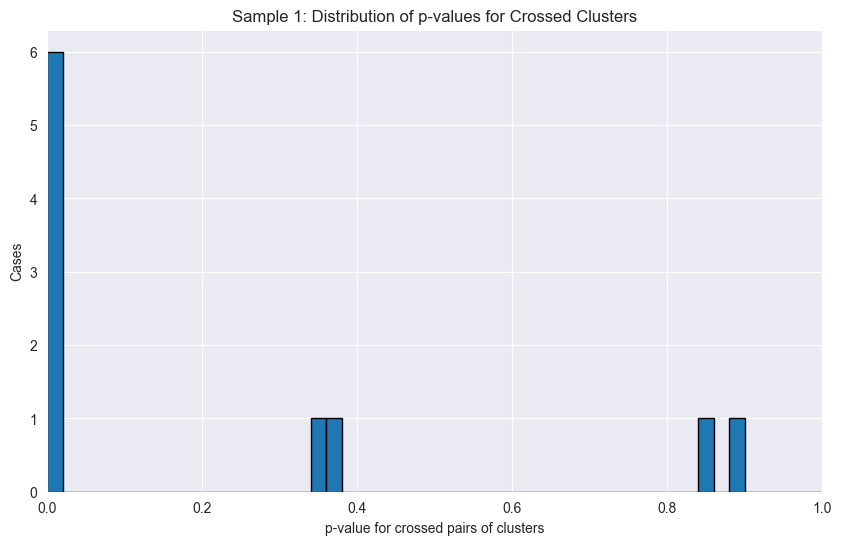

SAMPLE ID = 2
         size_df1  size_df2  df1_to_df2
cluster                                
0           15617     15681    0.995919
1           21570     21056    1.024411
2           22704     21984    1.032751
3           24387     25095    0.971787
4           15202     15716    0.967294

Sample:2 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 0.1503 ; p-value = 6.9821e-01 ; n_sigma = -0.5193
CLUSTER 1: chi2 = 7.8462 ; p-value = 5.0929e-03 ; n_sigma = 2.5695
CLUSTER 2: chi2 = 14.8968 ; p-value = 1.1356e-04 ; n_sigma = 3.6868
CLUSTER 3: chi2 = 13.4225 ; p-value = 2.4863e-04 ; n_sigma = 3.4822
CLUSTER 4: chi2 = 10.0683 ; p-value = 1.5084e-03 ; n_sigma = 2.9660
Sample:2 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 3.5616 ; p-value = 5.9132e-02 ; n_sigma = 1.5621
CLUSTERS 2/0: chi2 = 6.0321 ; p-value = 1.4048e-02 ; n_sigma = 2.1960
CLUSTERS 2/1: chi2 = 0.3504 ; p-value = 5.5386e-01 ; n_sigma = -0.1354
CLUSTERS 3/0: chi2 = 2.8590 ; p-value = 9.0863e-02 ; n_sigma = 1.3355
CLUSTERS 3/1: chi2 

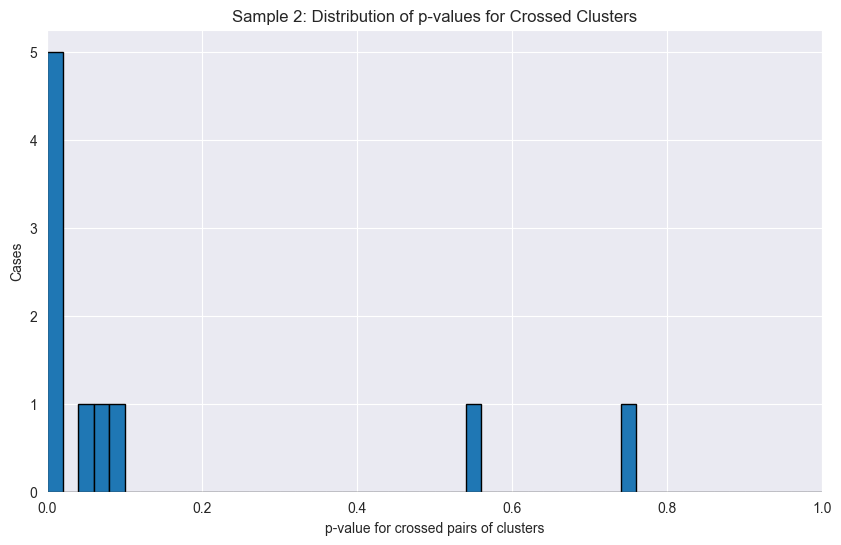

SAMPLE ID = 3
         size_df1  size_df2  df1_to_df2
cluster                                
0           22500     21856    1.029466
1           15339     15630    0.981382
2           24320     25025    0.971828
3           15427     15851    0.973251
4           21965     21184    1.036867

Sample:3 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 11.9775 ; p-value = 5.3846e-04 ; n_sigma = 3.2696
CLUSTER 1: chi2 = 3.2132 ; p-value = 7.3048e-02 ; n_sigma = 1.4535
CLUSTER 2: chi2 = 13.3336 ; p-value = 2.6069e-04 ; n_sigma = 3.4695
CLUSTER 3: chi2 = 6.7811 ; p-value = 9.2128e-03 ; n_sigma = 2.3570
CLUSTER 4: chi2 = 17.9788 ; p-value = 2.2338e-05 ; n_sigma = 4.0819
Sample:3 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 10.3827 ; p-value = 1.2720e-03 ; n_sigma = 3.0181
CLUSTERS 2/0: chi2 = 19.3253 ; p-value = 1.1023e-05 ; n_sigma = 4.2431
CLUSTERS 2/1: chi2 = 0.4454 ; p-value = 5.0450e-01 ; n_sigma = -0.0113
CLUSTERS 3/0: chi2 = 14.4020 ; p-value = 1.4765e-04 ; n_sigma = 3.6194
CLUSTERS 3/1: chi

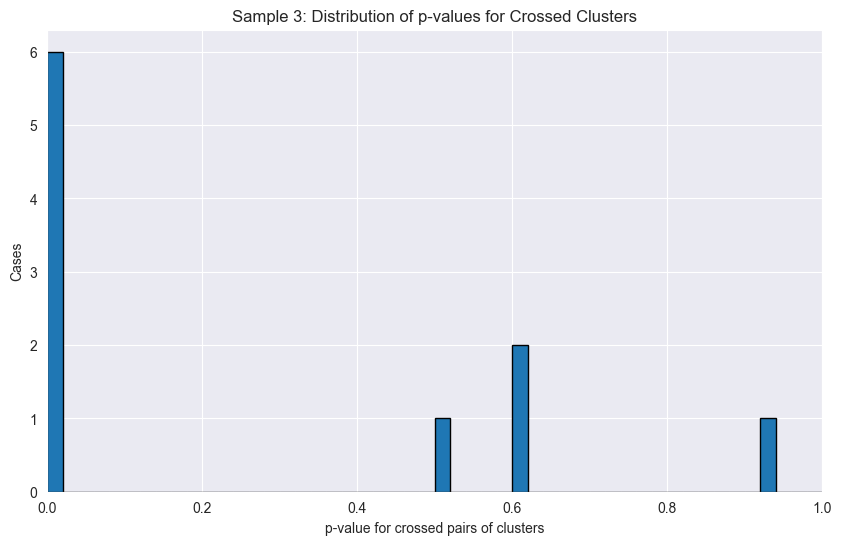

SAMPLE ID = 4
         size_df1  size_df2  df1_to_df2
cluster                                
0           21907     21224    1.032181
1           24298     24743    0.982015
2           22640     22194    1.020096
3           15229     15605    0.975905
4           15433     15731    0.981057

Sample:4 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 13.7490 ; p-value = 2.0893e-04 ; n_sigma = 3.5285
CLUSTER 1: chi2 = 5.3257 ; p-value = 2.1013e-02 ; n_sigma = 2.0333
CLUSTER 2: chi2 = 5.6931 ; p-value = 1.7032e-02 ; n_sigma = 2.1193
CLUSTER 3: chi2 = 5.3920 ; p-value = 2.0229e-02 ; n_sigma = 2.0490
CLUSTER 4: chi2 = 3.3529 ; p-value = 6.7085e-02 ; n_sigma = 1.4979
Sample:4 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 14.1894 ; p-value = 1.6530e-04 ; n_sigma = 3.5901
CLUSTERS 2/0: chi2 = 0.7504 ; p-value = 3.8634e-01 ; n_sigma = 0.2889
CLUSTERS 2/1: chi2 = 8.4367 ; p-value = 3.6773e-03 ; n_sigma = 2.6803
CLUSTERS 3/0: chi2 = 14.0707 ; p-value = 1.7607e-04 ; n_sigma = 3.5736
CLUSTERS 3/1: chi2 = 

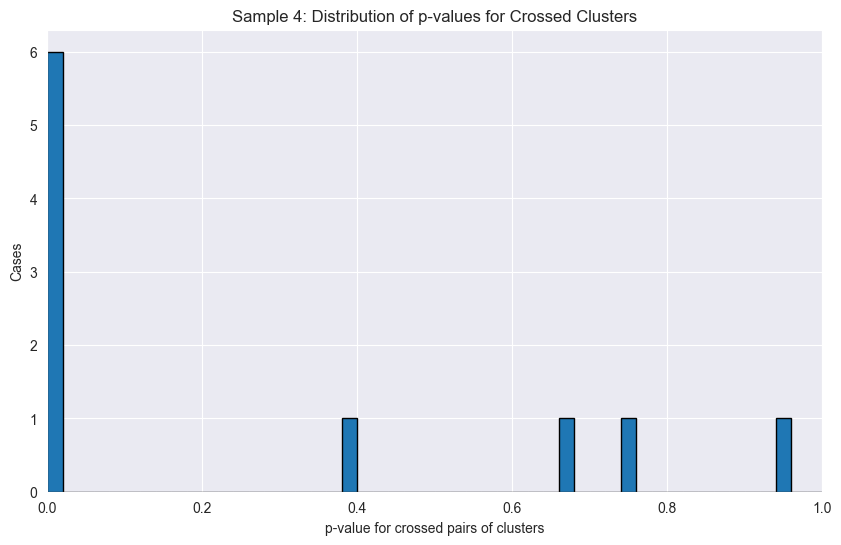

SAMPLE ID = 5
         size_df1  size_df2  df1_to_df2
cluster                                
0           24030     24899    0.965099
1           21864     21245    1.029136
2           22615     21795    1.037623
3           15611     16051    0.972587
4           15409     15571    0.989596

Sample:5 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 20.3855 ; p-value = 6.3307e-06 ; n_sigma = 4.3659
CLUSTER 1: chi2 = 11.2938 ; p-value = 7.7765e-04 ; n_sigma = 3.1642
CLUSTER 2: chi2 = 19.4149 ; p-value = 1.0518e-05 ; n_sigma = 4.2536
CLUSTER 3: chi2 = 7.2317 ; p-value = 7.1629e-03 ; n_sigma = 2.4490
CLUSTER 4: chi2 = 0.9901 ; p-value = 3.1973e-01 ; n_sigma = 0.4685
Sample:5 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 23.5789 ; p-value = 1.1989e-06 ; n_sigma = 4.7166
CLUSTERS 2/0: chi2 = 30.4764 ; p-value = 3.3795e-08 ; n_sigma = 5.3975
CLUSTERS 2/1: chi2 = 0.3606 ; p-value = 5.4817e-01 ; n_sigma = -0.1210
CLUSTERS 3/0: chi2 = 0.2794 ; p-value = 5.9713e-01 ; n_sigma = -0.2459
CLUSTERS 3/1: chi

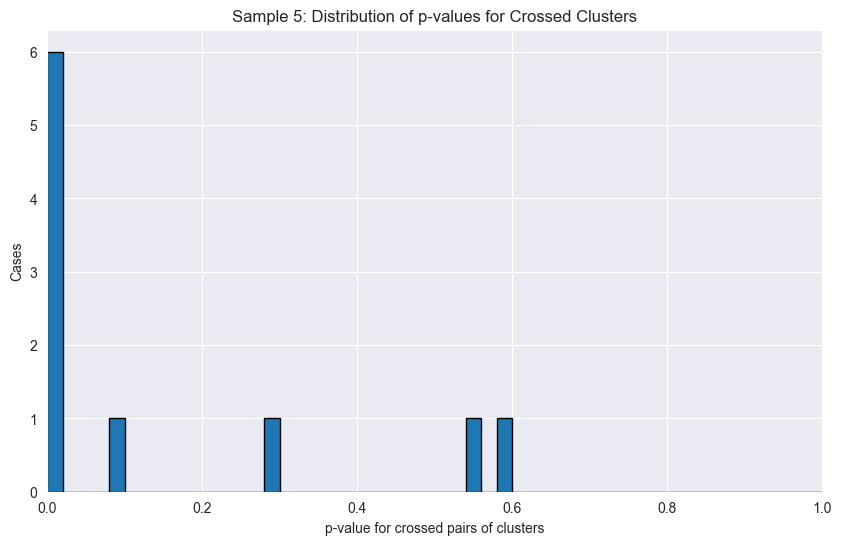

SAMPLE ID = 6
         size_df1  size_df2  df1_to_df2
cluster                                
0           22612     22233    1.017047
1           15345     15553    0.986626
2           24204     24720    0.979126
3           21793     21125    1.031621
4           15558     15891    0.979045

Sample:6 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 4.1071 ; p-value = 4.2704e-02 ; n_sigma = 1.7201
CLUSTER 1: chi2 = 1.6402 ; p-value = 2.0030e-01 ; n_sigma = 0.8405
CLUSTER 2: chi2 = 7.1767 ; p-value = 7.3855e-03 ; n_sigma = 2.4379
CLUSTER 3: chi2 = 13.1982 ; p-value = 2.8021e-04 ; n_sigma = 3.4501
CLUSTER 4: chi2 = 4.1588 ; p-value = 4.1419e-02 ; n_sigma = 1.7345
Sample:6 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 4.1869 ; p-value = 4.0737e-02 ; n_sigma = 1.7422
CLUSTERS 2/0: chi2 = 8.4072 ; p-value = 3.7374e-03 ; n_sigma = 2.6749
CLUSTERS 2/1: chi2 = 0.2681 ; p-value = 6.0462e-01 ; n_sigma = -0.2653
CLUSTERS 3/0: chi2 = 1.0956 ; p-value = 2.9523e-01 ; n_sigma = 0.5382
CLUSTERS 3/1: chi2 = 8

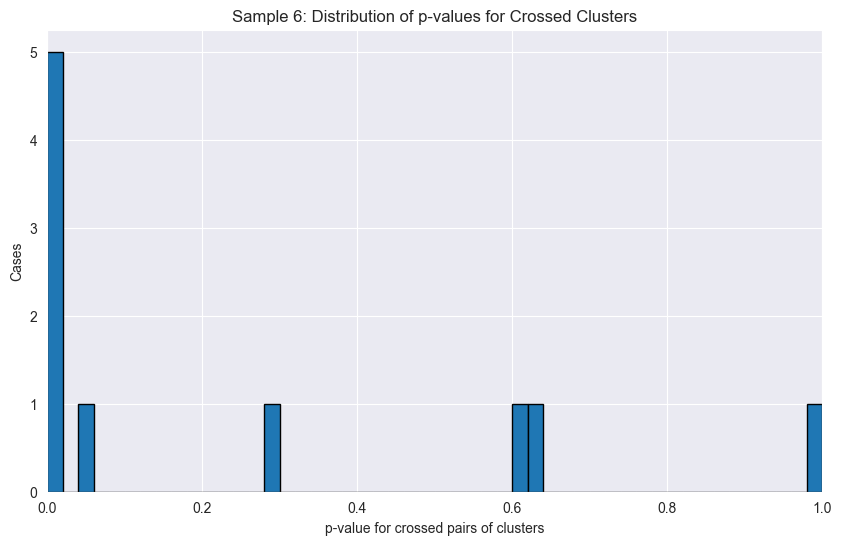

SAMPLE ID = 7
         size_df1  size_df2  df1_to_df2
cluster                                
0           15466     15894    0.973072
1           21835     21226    1.028691
2           22614     22079    1.024231
3           24441     24720    0.988714
4           15129     15590    0.970430

Sample:7 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 6.8952 ; p-value = 8.6426e-03 ; n_sigma = 2.3806
CLUSTER 1: chi2 = 10.9401 ; p-value = 9.4104e-04 ; n_sigma = 3.1082
CLUSTER 2: chi2 = 8.2164 ; p-value = 4.1513e-03 ; n_sigma = 2.6395
CLUSTER 3: chi2 = 2.0844 ; p-value = 1.4881e-01 ; n_sigma = 1.0416
CLUSTER 4: chi2 = 8.1382 ; p-value = 4.3341e-03 ; n_sigma = 2.6249
Sample:7 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 13.9586 ; p-value = 1.8688e-04 ; n_sigma = 3.5579
CLUSTERS 2/0: chi2 = 12.0439 ; p-value = 5.1963e-04 ; n_sigma = 3.2797
CLUSTERS 2/1: chi2 = 0.0992 ; p-value = 7.5280e-01 ; n_sigma = -0.6833
CLUSTERS 3/0: chi2 = 1.2012 ; p-value = 2.7308e-01 ; n_sigma = 0.6035
CLUSTERS 3/1: chi2 =

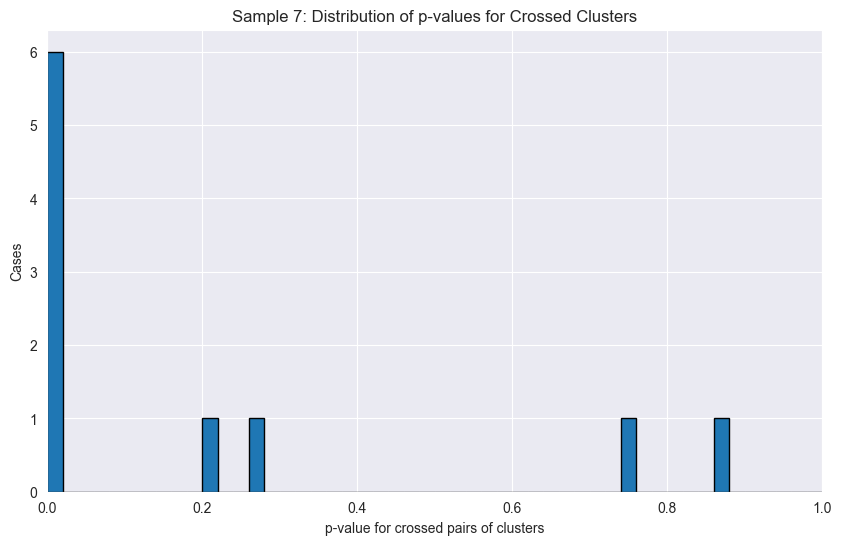

SAMPLE ID = 8
         size_df1  size_df2  df1_to_df2
cluster                                
0           15678     15879    0.987342
1           21968     21452    1.024054
2           22638     21989    1.029515
3           15673     15701    0.998217
4           23570     24482    0.962748

Sample:8 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 1.5050 ; p-value = 2.1990e-01 ; n_sigma = 0.7725
CLUSTER 1: chi2 = 7.8022 ; p-value = 5.2182e-03 ; n_sigma = 2.5610
CLUSTER 2: chi2 = 12.1117 ; p-value = 5.0105e-04 ; n_sigma = 3.2899
CLUSTER 3: chi2 = 0.0276 ; p-value = 8.6815e-01 ; n_sigma = -1.1177
CLUSTER 4: chi2 = 22.7332 ; p-value = 1.8613e-06 ; n_sigma = 4.6263
Sample:8 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 6.0526 ; p-value = 1.3886e-02 ; n_sigma = 2.2005
CLUSTERS 2/0: chi2 = 8.0426 ; p-value = 4.5691e-03 ; n_sigma = 2.6068
CLUSTERS 2/1: chi2 = 0.1503 ; p-value = 6.9821e-01 ; n_sigma = -0.5193
CLUSTERS 3/0: chi2 = 0.4610 ; p-value = 4.9713e-01 ; n_sigma = 0.0072
CLUSTERS 3/1: chi2 =

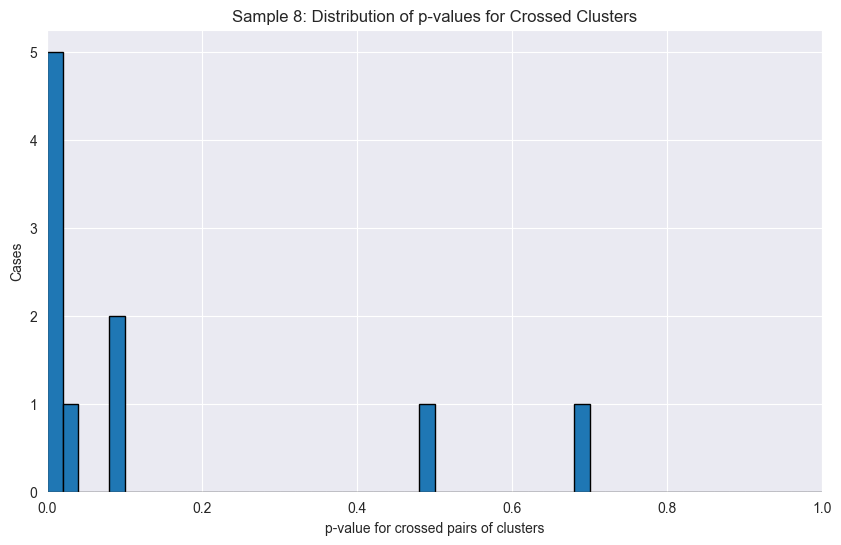

SAMPLE ID = 9
         size_df1  size_df2  df1_to_df2
cluster                                
0           24336     25019    0.972701
1           22681     22141    1.024389
2           21668     20912    1.036151
3           15285     15757    0.970045
4           15547     15700    0.990255

Sample:9 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 12.5116 ; p-value = 4.0443e-04 ; n_sigma = 3.3497
CLUSTER 1: chi2 = 8.3538 ; p-value = 3.8487e-03 ; n_sigma = 2.6651
CLUSTER 2: chi2 = 17.0082 ; p-value = 3.7219e-05 ; n_sigma = 3.9616
CLUSTER 3: chi2 = 8.4595 ; p-value = 3.6315e-03 ; n_sigma = 2.6845
CLUSTER 4: chi2 = 0.8763 ; p-value = 3.4921e-01 ; n_sigma = 0.3874
Sample:9 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 15.6886 ; p-value = 7.4672e-05 ; n_sigma = 3.7922
CLUSTERS 2/0: chi2 = 22.7533 ; p-value = 1.8419e-06 ; n_sigma = 4.6285
CLUSTERS 2/1: chi2 = 0.7000 ; p-value = 4.0278e-01 ; n_sigma = 0.2462
CLUSTERS 3/0: chi2 = 0.0329 ; p-value = 8.5602e-01 ; n_sigma = -1.0626
CLUSTERS 3/1: chi2 

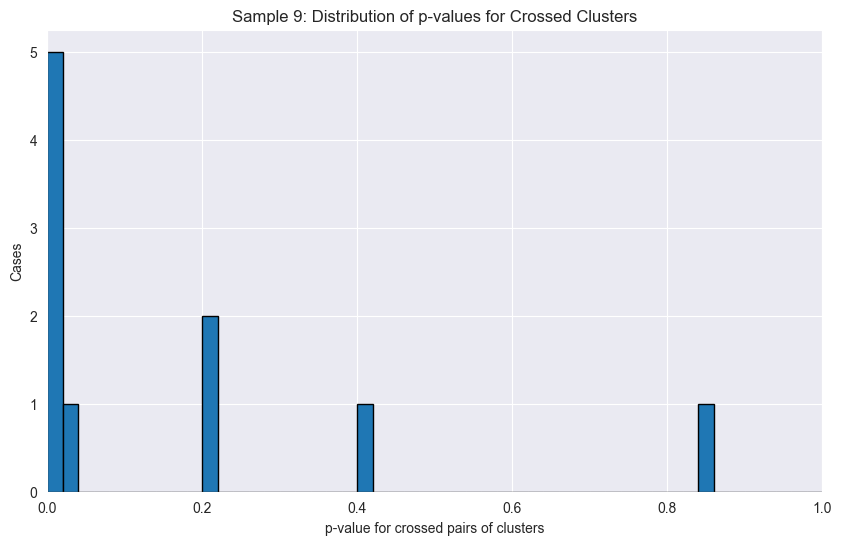

SAMPLE ID = 10
         size_df1  size_df2  df1_to_df2
cluster                                
0           15674     15990    0.980238
1           22403     22054    1.015825
2           24055     24369    0.987115
3           21918     21591    1.015145
4           15447     15519    0.995361

Sample:10 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 3.7231 ; p-value = 5.3664e-02 ; n_sigma = 1.6103
CLUSTER 1: chi2 = 3.5027 ; p-value = 6.1270e-02 ; n_sigma = 1.5442
CLUSTER 2: chi2 = 2.6695 ; p-value = 1.0229e-01 ; n_sigma = 1.2686
CLUSTER 3: chi2 = 3.1217 ; p-value = 7.7254e-02 ; n_sigma = 1.4238
CLUSTER 4: chi2 = 0.1926 ; p-value = 6.6075e-01 ; n_sigma = -0.4145
Sample:10 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 5.8435 ; p-value = 1.5635e-02 ; n_sigma = 2.1536
CLUSTERS 2/0: chi2 = 0.2270 ; p-value = 6.3377e-01 ; n_sigma = -0.3418
CLUSTERS 2/1: chi2 = 4.7340 ; p-value = 2.9571e-02 ; n_sigma = 1.8871
CLUSTERS 3/0: chi2 = 5.5747 ; p-value = 1.8222e-02 ; n_sigma = 2.0919
CLUSTERS 3/1: chi2 

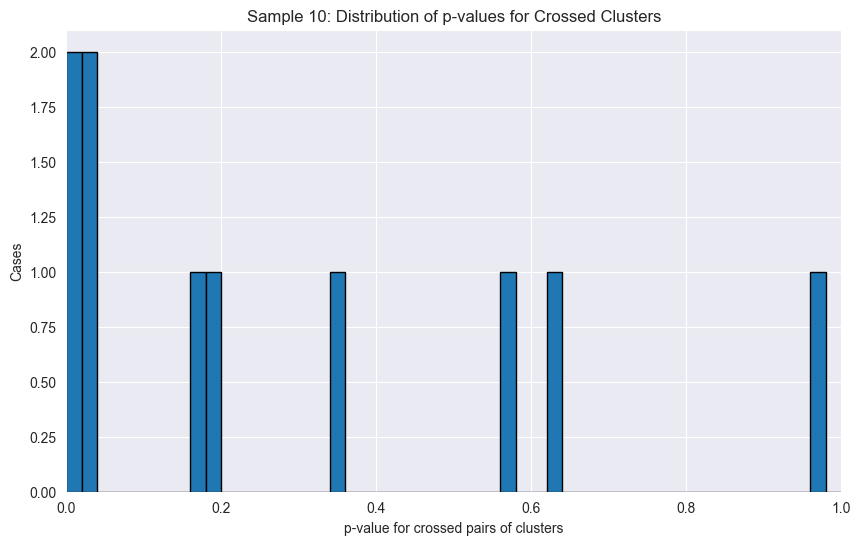

SAMPLE ID = 11
         size_df1  size_df2  df1_to_df2
cluster                                
0           24487     24739    0.989814
1           22446     22195    1.011309
2           21986     21169    1.038594
3           15706     15837    0.991728
4           14891     15580    0.955777

Sample:11 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 1.6977 ; p-value = 1.9259e-01 ; n_sigma = 0.8684
CLUSTER 1: chi2 = 1.8024 ; p-value = 1.7943e-01 ; n_sigma = 0.9175
CLUSTER 2: chi2 = 19.6747 ; p-value = 9.1808e-06 ; n_sigma = 4.2839
CLUSTER 3: chi2 = 0.6361 ; p-value = 4.2513e-01 ; n_sigma = 0.1888
CLUSTER 4: chi2 = 18.3264 ; p-value = 1.8611e-05 ; n_sigma = 4.1241
Sample:11 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 2.6799 ; p-value = 1.0162e-01 ; n_sigma = 1.2724
CLUSTERS 2/0: chi2 = 13.2542 ; p-value = 2.7197e-04 ; n_sigma = 3.4581
CLUSTERS 2/1: chi2 = 3.8608 ; p-value = 4.9428e-02 ; n_sigma = 1.6504
CLUSTERS 3/0: chi2 = 0.0161 ; p-value = 8.9914e-01 ; n_sigma = -1.2766
CLUSTERS 3/1: chi

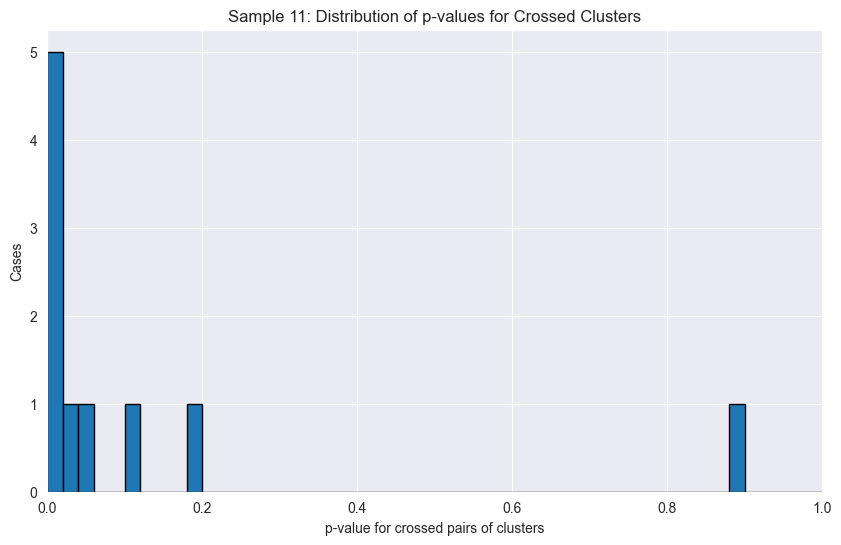

SAMPLE ID = 12
         size_df1  size_df2  df1_to_df2
cluster                                
0           22923     22034    1.040347
1           15203     15775    0.963740
2           15511     15684    0.988970
3           21412     21114    1.014114
4           24443     24931    0.980426

Sample:12 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 22.6259 ; p-value = 1.9681e-06 ; n_sigma = 4.6147
CLUSTER 1: chi2 = 12.4539 ; p-value = 4.1712e-04 ; n_sigma = 3.3412
CLUSTER 2: chi2 = 1.1236 ; p-value = 2.8914e-01 ; n_sigma = 0.5559
CLUSTER 3: chi2 = 2.6344 ; p-value = 1.0457e-01 ; n_sigma = 1.2559
CLUSTER 4: chi2 = 6.3781 ; p-value = 1.1554e-02 ; n_sigma = 2.2716
Sample:12 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 26.7420 ; p-value = 2.3251e-07 ; n_sigma = 5.0402
CLUSTERS 2/0: chi2 = 11.7573 ; p-value = 6.0604e-04 ; n_sigma = 3.2360
CLUSTERS 2/1: chi2 = 2.5687 ; p-value = 1.0900e-01 ; n_sigma = 1.2319
CLUSTERS 3/0: chi2 = 3.5372 ; p-value = 6.0005e-02 ; n_sigma = 1.5547
CLUSTERS 3/1: chi

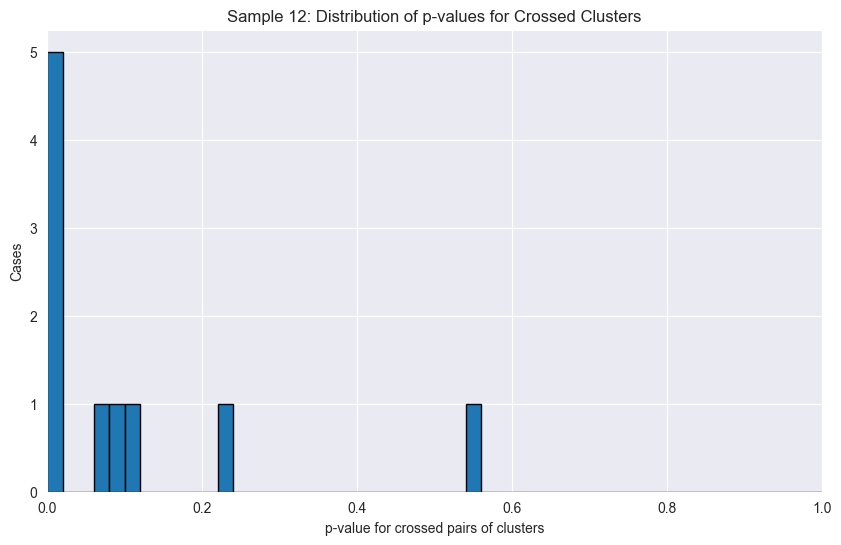

SAMPLE ID = 13
         size_df1  size_df2  df1_to_df2
cluster                                
0           15002     15661    0.957921
1           22654     22161    1.022246
2           21791     21216    1.027102
3           24229     24701    0.980891
4           15817     15762    1.003489

Sample:13 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 16.6769 ; p-value = 4.4317e-05 ; n_sigma = 3.9198
CLUSTER 1: chi2 = 6.9612 ; p-value = 8.3294e-03 ; n_sigma = 2.3942
CLUSTER 2: chi2 = 9.7597 ; p-value = 1.7838e-03 ; n_sigma = 2.9141
CLUSTER 3: chi2 = 6.0023 ; p-value = 1.4287e-02 ; n_sigma = 2.1893
CLUSTER 4: chi2 = 0.1097 ; p-value = 7.4054e-01 ; n_sigma = -0.6450
Sample:13 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 19.1565 ; p-value = 1.2043e-05 ; n_sigma = 4.2232
CLUSTERS 2/0: chi2 = 21.6853 ; p-value = 3.2124e-06 ; n_sigma = 4.5119
CLUSTERS 2/1: chi2 = 0.1185 ; p-value = 7.3066e-01 ; n_sigma = -0.6148
CLUSTERS 3/0: chi2 = 2.6218 ; p-value = 1.0541e-01 ; n_sigma = 1.2513
CLUSTERS 3/1: ch

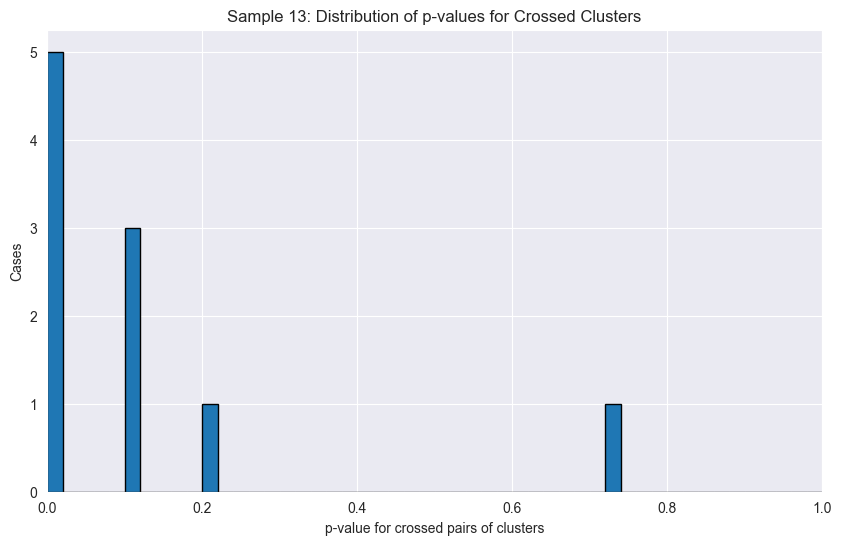

SAMPLE ID = 14
         size_df1  size_df2  df1_to_df2
cluster                                
0           15469     15739    0.982845
1           22886     22111    1.035050
2           23761     24637    0.964444
3           21767     20998    1.036623
4           15607     16055    0.972096

Sample:14 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 2.7474 ; p-value = 9.7415e-02 ; n_sigma = 1.2964
CLUSTER 1: chi2 = 17.1786 ; p-value = 3.4024e-05 ; n_sigma = 3.9830
CLUSTER 2: chi2 = 20.8696 ; p-value = 4.9164e-06 ; n_sigma = 4.4208
CLUSTER 3: chi2 = 17.5434 ; p-value = 2.8082e-05 ; n_sigma = 4.0284
CLUSTER 4: chi2 = 7.4976 ; p-value = 6.1780e-03 ; n_sigma = 2.5018
Sample:14 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 12.2863 ; p-value = 4.5629e-04 ; n_sigma = 3.3162
CLUSTERS 2/0: chi2 = 1.6753 ; p-value = 1.9555e-01 ; n_sigma = 0.8576
CLUSTERS 2/1: chi2 = 29.0238 ; p-value = 7.1493e-08 ; n_sigma = 5.2614
CLUSTERS 3/0: chi2 = 12.7454 ; p-value = 3.5689e-04 ; n_sigma = 3.3842
CLUSTERS 3/1: c

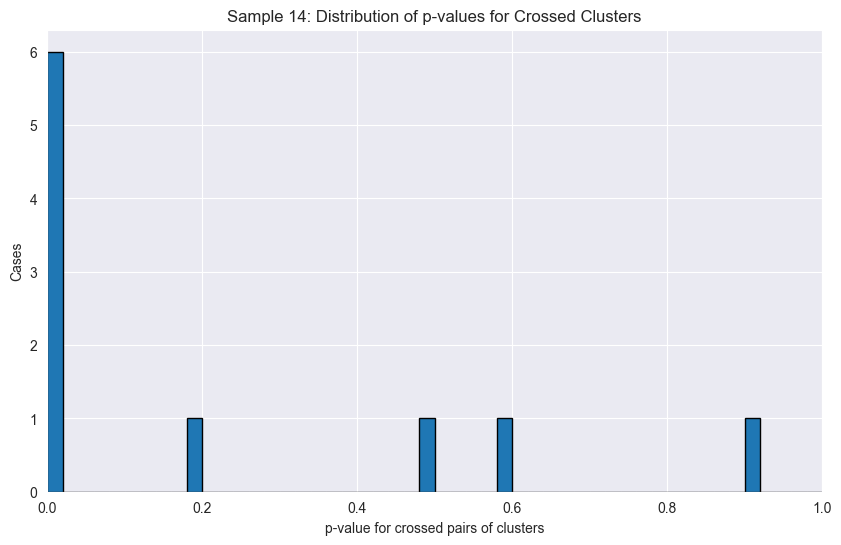

SAMPLE ID = 15
         size_df1  size_df2  df1_to_df2
cluster                                
0           21987     21261    1.034147
1           24008     24659    0.973600
2           15137     15573    0.972003
3           22786     22306    1.021519
4           15571     15703    0.991594

Sample:15 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 15.5070 ; p-value = 8.2202e-05 ; n_sigma = 3.7682
CLUSTER 1: chi2 = 11.4733 ; p-value = 7.0603e-04 ; n_sigma = 3.1922
CLUSTER 2: chi2 = 7.2794 ; p-value = 6.9749e-03 ; n_sigma = 2.4586
CLUSTER 3: chi2 = 6.5694 ; p-value = 1.0375e-02 ; n_sigma = 2.3125
CLUSTER 4: chi2 = 0.6504 ; p-value = 4.1996e-01 ; n_sigma = 0.2020
Sample:15 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 20.7740 ; p-value = 5.1680e-06 ; n_sigma = 4.4100
CLUSTERS 2/0: chi2 = 17.1785 ; p-value = 3.4026e-05 ; n_sigma = 3.9830
CLUSTERS 2/1: chi2 = 0.0111 ; p-value = 9.1611e-01 ; n_sigma = -1.3794
CLUSTERS 3/0: chi2 = 0.8207 ; p-value = 3.6498e-01 ; n_sigma = 0.3452
CLUSTERS 3/1: ch

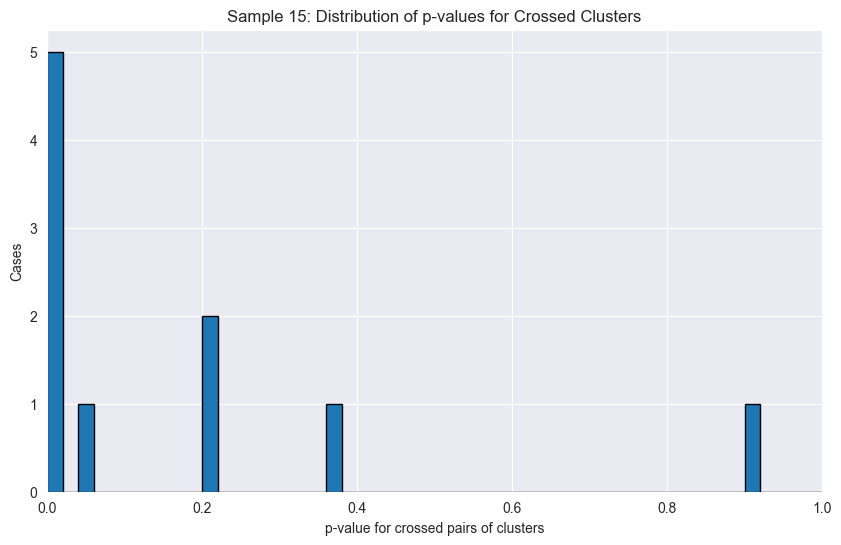

SAMPLE ID = 16
         size_df1  size_df2  df1_to_df2
cluster                                
0           15463     15749    0.981840
1           21992     21183    1.038191
2           24231     24621    0.984160
3           22379     22179    1.009018
4           15440     15795    0.977525

Sample:16 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 3.0836 ; p-value = 7.9086e-02 ; n_sigma = 1.4112
CLUSTER 1: chi2 = 19.2844 ; p-value = 1.1263e-05 ; n_sigma = 4.2383
CLUSTER 2: chi2 = 4.0987 ; p-value = 4.2917e-02 ; n_sigma = 1.7178
CLUSTER 3: chi2 = 1.1435 ; p-value = 2.8491e-01 ; n_sigma = 0.5683
CLUSTER 4: chi2 = 4.7546 ; p-value = 2.9220e-02 ; n_sigma = 1.8924
Sample:16 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 14.0473 ; p-value = 1.7827e-04 ; n_sigma = 3.5703
CLUSTERS 2/0: chi2 = 0.0242 ; p-value = 8.7636e-01 ; n_sigma = -1.1570
CLUSTERS 2/1: chi2 = 16.3115 ; p-value = 5.3737e-05 ; n_sigma = 3.8731
CLUSTERS 3/0: chi2 = 3.3935 ; p-value = 6.5453e-02 ; n_sigma = 1.5105
CLUSTERS 3/1: chi

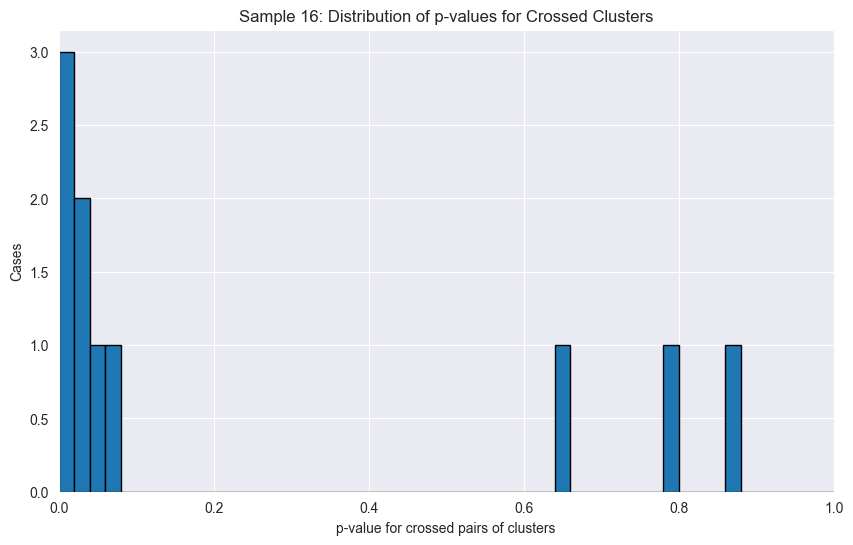

SAMPLE ID = 17
         size_df1  size_df2  df1_to_df2
cluster                                
0           15380     15968    0.963176
1           24258     24860    0.975784
2           21824     21041    1.037213
3           22780     22107    1.030443
4           15268     15550    0.981865

Sample:17 - UNCROSSED CLUSTERS IDS
CLUSTER 0: chi2 = 13.0348 ; p-value = 3.0575e-04 ; n_sigma = 3.4265
CLUSTER 1: chi2 = 9.7477 ; p-value = 1.7955e-03 ; n_sigma = 2.9120
CLUSTER 2: chi2 = 18.1580 ; p-value = 2.0331e-05 ; n_sigma = 4.1037
CLUSTER 3: chi2 = 12.9718 ; p-value = 3.1622e-04 ; n_sigma = 3.4173
CLUSTER 4: chi2 = 3.0289 ; p-value = 8.1794e-02 ; n_sigma = 1.3931
Sample:17 - CROSSED CLUSTERS IDS
CLUSTERS 1/0: chi2 = 0.7959 ; p-value = 3.7231e-01 ; n_sigma = 0.3257
CLUSTERS 2/0: chi2 = 24.7458 ; p-value = 6.5411e-07 ; n_sigma = 4.8385
CLUSTERS 2/1: chi2 = 21.2639 ; p-value = 4.0019e-06 ; n_sigma = 4.4651
CLUSTERS 3/0: chi2 = 20.9575 ; p-value = 4.6960e-06 ; n_sigma = 4.4307
CLUSTERS 3/1: c

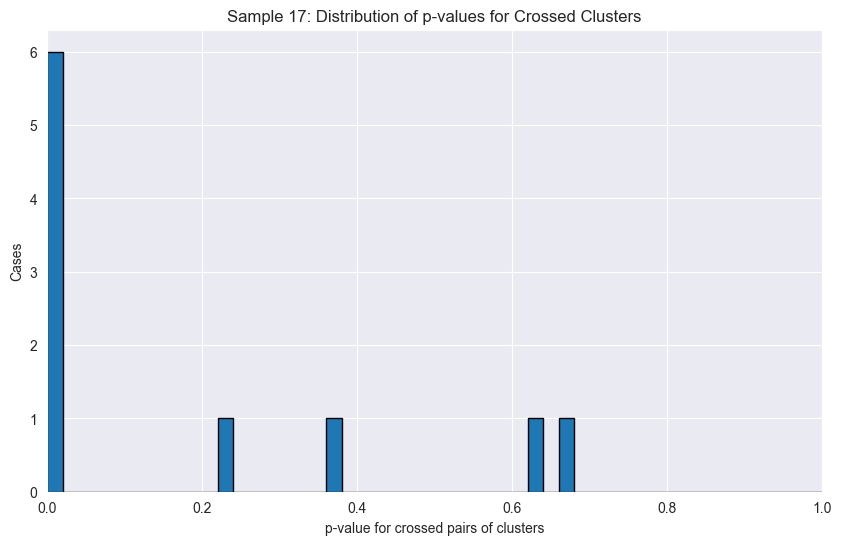

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


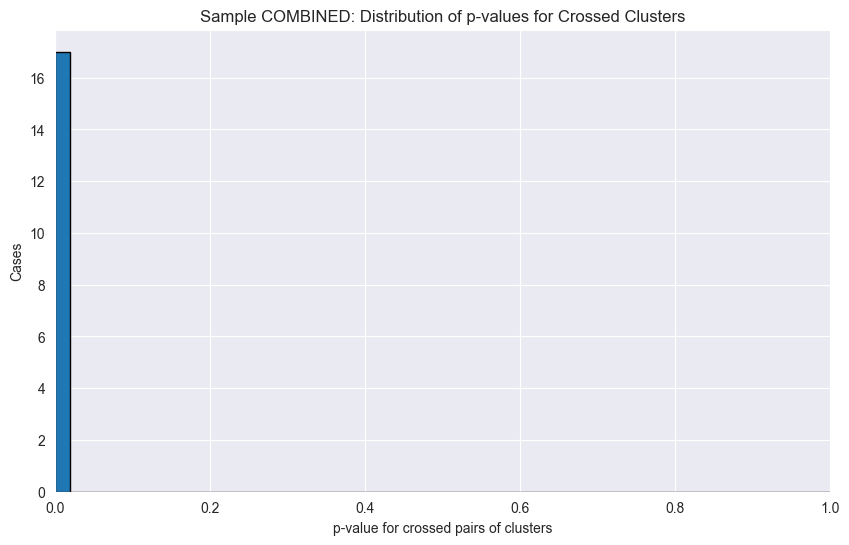

In [30]:
processed_images_flag = False
crossed_fisher_p_values = []

for i in range(1, max_sample+1):
    print("================================================================================================")
    print(f"SAMPLE ID = {i}")
    print("================================================================================================")
    img_minus_1_loaded = cv2.imread(f'cloud_points_to_images_minus/img_minus_{i}.png')
    img_1_loaded = cv2.imread(f'cloud_points_to_images/img_{i}.png')
    if processed_images_flag:
        detect_image_differences(img_minus_1_loaded, img_1_loaded, 5)
    cluster_counts_df1, cluster_counts_df2 = points_per_cluster(img_minus_1_loaded, img_1_loaded, 5)
    crossed_clusters_p_values, combined_p_value_chi2 = statistical_tests(cluster_counts_df1, cluster_counts_df2, 5, i)
    crossed_fisher_p_values.append(combined_p_value_chi2)
    plot_distributions(crossed_clusters_p_values, i)
    
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
plot_distributions(crossed_fisher_p_values, "COMBINED")

# Podsumowanie i wnioski:
## Opis:

## Hipotezy:
H0: Obraz -1 i 1 są takie same.
H1 (alterantywna): Obraz -1 i 1 są różne.
## Omówiene wyników:
Wartości p-value są znacznie mniejsze od poziomu istotności (z reguły jest to próg wynoszący 0.05). Zatem:
p-value <<< threshold = 0.05 => odrzucamy H0 na rzecz H1
Wynika z tego zatem że obrazy są różne. Bardzo niskie osiągane wartość oznaczają, że różnice są znaczące 10^-12 dla metody Fishera.

Otrzymanie wykresów (rozkład płaski dla p-value) jest ciężki do uzyskania z uwagi na zbyt duże przybliżenie i zaniechanie całego przebiegu wykresu funkcji opisującej ten rozkład. Należy mięc więcej próbek (więcej wartości p-value). Jest to prawdą dla sytuacji klastrów nieskrosowanych (5 wartości), jak i skorosowanych (10 wartości). Charakterystyka wykresu normalnego powinna opierać się na dużej liczbie danych, aby dobrze odzwierciedlać prawdziwy jego charakter.
Jeśli wszystkie wartości p-value mieszczą się w granicach trzech sigm (trzech odchyleń standardowych), sugeruje to pewną spójność. Oznacza to, że różnice między dwoma badanymi obrazami, są istotne statystycznie.

"To pokazuje, że metoda klasteryzacji może być czuła na różnice na poziomie promili a interpretacja klastrów nie musi być taka trudna, jak powszechne przekonanie."

## Porównanie
Porównanie z wynikami otrzymanymi poprzez zastosowanie sieci grafowych i CNN/VGG16.